In [1]:
import numpy as np
import pandas as pd
from seqeval.metrics import accuracy_score
import torch.nn as nn
from tqdm import tqdm, trange
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
import re
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForTokenClassification
from transformers import BertForTokenClassification, AdamW
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score,classification_report
from concurrent.futures import ThreadPoolExecutor
from keras_preprocessing.sequence import pad_sequences
from modules.NER_functions import *

/home/onyxia/work/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv('./data/train.csv')
df = pd.read_csv('../data/clini_data.csv')

/tmp/ipykernel_13015/2479533425.py:2: DtypeWarning: Columns (2,3,4,5,10,11,12,13,14,15,17,18,19,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,42,43,68,79,80,81,82,88,89,94,95,97,98,99,100,101,102,104,105,109,110,111,112,113,114,115,116,118,121,122,151,163,169,184,192,193,194,195,196,200,206,209,210,212,213,214,215,216,217,218,219,220,222,223,225,226,228,229,230,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,262,263,264,265,266,275,279,280,282,283,284,285,286,287,300,301,302,303,304,308,320,321,322,324,325,326) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/clini_data.csv')


In [3]:
getter = SentenceGetter(df_train)

In [4]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['With',
 'severe',
 'comorbidities',
 ',',
 'such',
 'as',
 'cardiovascular',
 'disease',
 ',',
 'chronic',
 'obstructive',
 'pulmonary',
 'disease',
 ',',
 'diabetes',
 'mellitus',
 ',',
 'and',
 'chronic',
 'renal',
 'dysfunction',
 '.']

In [5]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'B-Condition', 'O', 'O', 'O', 'B-Condition', 'I-Condition', 'O', 'B-Condition', 'I-Condition', 'I-Condition', 'I-Condition', 'O', 'B-Condition', 'I-Condition', 'O', 'O', 'B-Condition', 'I-Condition', 'I-Condition', 'O']


In [7]:
tag_values = list(set(df_train["Label"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'I-Procedure': 0,
 'B-Drug': 1,
 'I-Condition': 2,
 'I-Person': 3,
 'B-Condition': 4,
 'O': 5,
 'I-Observation': 6,
 'B-Procedure': 7,
 'B-Person': 8,
 'B-Mood': 9,
 'I-Mood': 10,
 'B-Observation': 11,
 'I-Drug': 12,
 'PAD': 13}

In [8]:
model = Bert_Model(sentences=sentences, labels=labels, tag_values=tag_values, tokenizer="dmis-lab/biobert-v1.1")

tokenizer_config.json: 100%|██████████| 49.0/49.0 [00:00<00:00, 95.7kB/s]
vocab.txt: 100%|██████████| 213k/213k [00:00<00:00, 1.31MB/s]
config.json: 100%|██████████| 462/462 [00:00<00:00, 474kB/s]


In [9]:
model.getparam(100)

In [10]:
model.preprocess()

pytorch_model.bin: 100%|██████████| 433M/433M [00:03<00:00, 110MB/s]  
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/onyxia/work/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
model.train_eval(epochs=8,weight=[1]*len(tag2idx))

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Average train loss: 0.20901072313708643
Validation loss: 0.09825205334251927
Validation Accuracy: 0.8479974936034672
Validation F1-Score: 0.8617134889122638


/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/pytho

Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.78      0.80      0.79      2038
       B-Drug       0.82      0.84      0.83       774
       B-Mood       0.00      0.00      0.00        42
B-Observation       0.50      0.02      0.05       211
     B-Person       0.80      0.26      0.39       172
  B-Procedure       0.76      0.60      0.67       590
  I-Condition       0.69      0.75      0.72      1588
       I-Drug       0.59      0.72      0.65       358
       I-Mood       0.00      0.00      0.00        26
I-Observation       0.62      0.02      0.04       249
     I-Person       0.00      0.00      0.00        27
  I-Procedure       0.72      0.62      0.67       531
            O       0.90      0.94      0.92     12545
          PAD       0.00      0.00      0.00         0

     accuracy                           0.85     19151
    macro avg       0.51      0.40      0.41     19151
 weighted avg       0.84      0.85     

Epoch:  12%|█▎        | 1/8 [09:24<1:05:49, 564.22s/it]

Model saved successfully.
Average train loss: 0.0866268000149879
Validation loss: 0.08764307152840399
Validation Accuracy: 0.8640279880946165
Validation F1-Score: 0.8716858987322837


/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.82      0.81      0.82      2038
       B-Drug       0.82      0.83      0.82       774
       B-Mood       0.38      0.12      0.18        42
B-Observation       0.50      0.25      0.33       211
     B-Person       0.80      0.65      0.72       172
  B-Procedure       0.75      0.73      0.74       590
  I-Condition       0.75      0.75      0.75      1588
       I-Drug       0.55      0.85      0.67       358
       I-Mood       1.00      0.04      0.07        26
I-Observation       0.48      0.06      0.10       249
     I-Person       0.00      0.00      0.00        27
  I-Procedure       0.77      0.63      0.70       531
            O       0.92      0.94      0.93     12545

     accuracy                           0.86     19151
    macro avg       0.66      0.51      0.53     19151
 weighted avg       0.86      0.86      0.86     19151




Epoch:  25%|██▌       | 2/8 [18:49<56:30, 565.07s/it]  

Model saved successfully.
Average train loss: 0.06514143924759601
Validation loss: 0.08422471967435652
Validation Accuracy: 0.8689363479713853
Validation F1-Score: 0.8753843830605633


/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.84      0.82      0.83      2038
       B-Drug       0.88      0.81      0.84       774
       B-Mood       0.47      0.21      0.30        42
B-Observation       0.54      0.28      0.37       211
     B-Person       0.82      0.74      0.78       172
  B-Procedure       0.70      0.73      0.71       590
  I-Condition       0.77      0.76      0.76      1588
       I-Drug       0.73      0.73      0.73       358
       I-Mood       0.64      0.27      0.38        26
I-Observation       0.38      0.11      0.17       249
     I-Person       0.00      0.00      0.00        27
  I-Procedure       0.70      0.69      0.69       531
            O       0.91      0.94      0.93     12545

     accuracy                           0.87     19151
    macro avg       0.64      0.55      0.58     19151
 weighted avg       0.86      0.87      0.86     19151




Epoch:  38%|███▊      | 3/8 [28:04<46:41, 560.30s/it]

Model saved successfully.
Average train loss: 0.05074209123549442
Validation loss: 0.0872593514861599
Validation Accuracy: 0.8714427445042034
Validation F1-Score: 0.8786719601319117


/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 4

Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.85      0.81      0.83      2038
       B-Drug       0.84      0.87      0.86       774
       B-Mood       0.45      0.24      0.31        42
B-Observation       0.57      0.20      0.30       211
     B-Person       0.88      0.65      0.75       172
  B-Procedure       0.79      0.68      0.73       590
  I-Condition       0.76      0.76      0.76      1588
       I-Drug       0.70      0.84      0.77       358
       I-Mood       0.53      0.31      0.39        26
I-Observation       0.39      0.13      0.19       249
     I-Person       0.00      0.00      0.00        27
  I-Procedure       0.73      0.69      0.71       531
            O       0.91      0.95      0.93     12545

     accuracy                           0.87     19151
    macro avg       0.65      0.55      0.58     19151
 weighted avg       0.86      0.87      0.86     19151


Average train loss: 0.039595048459026

/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onyxia/work/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  62%|██████▎   | 5

Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.82      0.83      0.83      2038
       B-Drug       0.83      0.86      0.85       774
       B-Mood       0.33      0.29      0.31        42
B-Observation       0.54      0.28      0.37       211
     B-Person       0.80      0.77      0.78       172
  B-Procedure       0.75      0.68      0.72       590
  I-Condition       0.75      0.77      0.76      1588
       I-Drug       0.71      0.81      0.76       358
       I-Mood       0.36      0.38      0.37        26
I-Observation       0.28      0.14      0.19       249
     I-Person       0.00      0.00      0.00        27
  I-Procedure       0.72      0.68      0.70       531
            O       0.92      0.93      0.93     12545

     accuracy                           0.87     19151
    macro avg       0.60      0.57      0.58     19151
 weighted avg       0.86      0.87      0.86     19151


Average train loss: 0.031785639682217

Epoch:  75%|███████▌  | 6/8 [55:43<18:29, 554.74s/it]

Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.82      0.84      0.83      2038
       B-Drug       0.87      0.82      0.84       774
       B-Mood       0.37      0.36      0.36        42
B-Observation       0.53      0.36      0.43       211
     B-Person       0.78      0.81      0.80       172
  B-Procedure       0.72      0.75      0.74       590
  I-Condition       0.75      0.78      0.76      1588
       I-Drug       0.74      0.76      0.75       358
       I-Mood       0.29      0.38      0.33        26
I-Observation       0.30      0.13      0.18       249
     I-Person       0.22      0.07      0.11        27
  I-Procedure       0.70      0.71      0.70       531
            O       0.92      0.93      0.93     12545

     accuracy                           0.87     19151
    macro avg       0.62      0.59      0.60     19151
 weighted avg       0.86      0.87      0.86     19151


Average train loss: 0.027114941342984

Epoch:  88%|████████▊ | 7/8 [1:04:52<09:12, 552.84s/it]

Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.83      0.85      0.84      2038
       B-Drug       0.85      0.85      0.85       774
       B-Mood       0.41      0.33      0.37        42
B-Observation       0.53      0.33      0.40       211
     B-Person       0.80      0.80      0.80       172
  B-Procedure       0.75      0.73      0.74       590
  I-Condition       0.76      0.77      0.77      1588
       I-Drug       0.72      0.78      0.75       358
       I-Mood       0.27      0.31      0.29        26
I-Observation       0.27      0.12      0.17       249
     I-Person       0.22      0.07      0.11        27
  I-Procedure       0.70      0.67      0.69       531
            O       0.92      0.93      0.93     12545

     accuracy                           0.87     19151
    macro avg       0.62      0.58      0.59     19151
 weighted avg       0.86      0.87      0.87     19151


Average train loss: 0.023681339754399

Epoch: 100%|██████████| 8/8 [1:13:59<00:00, 554.88s/it]

Classification Report:
                precision    recall  f1-score   support

  B-Condition       0.83      0.85      0.84      2038
       B-Drug       0.85      0.85      0.85       774
       B-Mood       0.35      0.36      0.35        42
B-Observation       0.51      0.33      0.40       211
     B-Person       0.82      0.81      0.82       172
  B-Procedure       0.74      0.73      0.74       590
  I-Condition       0.77      0.77      0.77      1588
       I-Drug       0.72      0.77      0.74       358
       I-Mood       0.28      0.35      0.31        26
I-Observation       0.25      0.13      0.17       249
     I-Person       0.18      0.07      0.11        27
  I-Procedure       0.70      0.66      0.68       531
            O       0.92      0.93      0.93     12545

     accuracy                           0.87     19151
    macro avg       0.61      0.59      0.59     19151
 weighted avg       0.86      0.87      0.87     19151




In [19]:
model.tag_values

['I-Procedure',
 'B-Drug',
 'I-Condition',
 'I-Person',
 'B-Condition',
 'O',
 'I-Observation',
 'B-Procedure',
 'B-Person',
 'B-Mood',
 'I-Mood',
 'B-Observation',
 'I-Drug',
 'PAD']

In [17]:
model.predict("Inclusion Criteria")

[('inclusion', 'O'), ('criteria', 'O')]

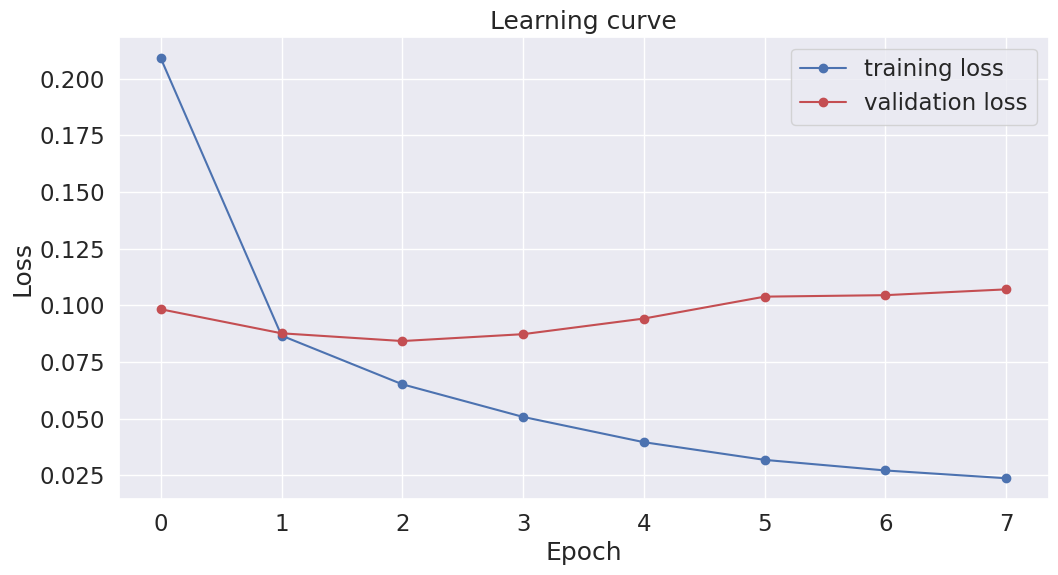

In [12]:
model.plotloss()

In [13]:
model.predict("This is a cancer")

[('this', 'O'), ('is', 'O'), ('a', 'O'), ('cancer', 'B-Condition')]

In [14]:
model.batch_predict(['a patient with diabete', 'under chemotherapy'])

2it [00:00, 16.53it/s]


[[('a', 'O'),
  ('patient', 'O'),
  ('with', 'O'),
  ('di', 'B-Condition'),
  ('##abe', 'B-Condition'),
  ('##te', 'B-Condition')],
 [('under', 'O'),
  ('ch', 'I-Procedure'),
  ('##em', 'B-Procedure'),
  ('##otherapy', 'B-Procedure')]]

In [16]:
model.save_model('./model/model2')